In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn
from torchvision import transforms
import argparse
import numpy as np
import random

os.environ["ZE_ENABLE_TRACING_LAYER"] = "1"

[W414 13:12:57.591982892 OperatorEntry.cpp:154] Warning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::_validate_compressed_sparse_indices(bool is_crow, Tensor compressed_idx, Tensor plain_idx, int cdim, int dim, int nnz) -> ()
    registered at /pytorch/build/aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: XPU
  previous kernel: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:30477
       new kernel: registered at /build/intel-pytorch-extension/build/Release/csrc/gpu/csrc/aten/generated/ATen/RegisterXPU.cpp:468 (function operator())


[2025-04-14 13:13:02,304] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to xpu (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [3]:
# Obtém o caminho absoluto para o diretório 'src'
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adiciona o diretório 'src' ao sys.path
if src_path not in sys.path:
    sys.path.append(src_path)

# Agora você pode importar módulos de dentro de 'src' como se fosse um pacote de nível superior

In [16]:
import clip
import cafe
import aux
import emotion_datasets
from cafe.model import Model
from aux.visualize_batch import *
from aux.train_model import *
from emotion_datasets import FERPlusDataset

In [5]:
print(f"PyTorch Version: {torch.__version__}")
device = torch.device('xpu' if torch.xpu.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch Version: 2.6.0+xpu
Using device: xpu


In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('--raf_path', type=str, default='../../data/raf-basic', help='raf_dataset_path')
parser.add_argument('--resnet50_path', type=str, default='../../data/resnet50_ft_weight.pkl', help='pretrained_backbone_path')
parser.add_argument('--label_path', type=str, default='list_patition_label.txt', help='label_path')
parser.add_argument('--workers', type=int, default=2, help='number of workers')
parser.add_argument('--batch_size', type=int, default=32, help='batch_size')
parser.add_argument('--w', type=int, default=7, help='width of the attention map')
parser.add_argument('--h', type=int, default=7, help='height of the attention map')
parser.add_argument('--gpu', type=int, default=0, help='the number of the device')
parser.add_argument('--lam', type=float, default=5, help='kl_lambda')
parser.add_argument('--epochs', type=int, default=60, help='number of epochs')
args = parser.parse_args(args=[])

In [7]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

### Treinamento E Teste Codigos

In [8]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(3407)

In [9]:
model_path = '/home/uc1add2a09dc85742dea98fbdba71022/FER-generalizavel/models/resnet18_msceleb.pth'
model = Model(model_path = model_path)
model.to(device)

weight : torch.Size([7, 512])
bias : torch.Size([7])


Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [11]:
eval_transforms = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

In [12]:
train_transforms = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomErasing(scale=(0.02, 0.25))
    ])

In [ ]:
import torch.utils.data as data
import cv2
import pandas as pd
import os
# import image_utils
import random
import cv2
import numpy as np



class RafDataSet(data.Dataset):
    def __init__(self, raf_path, idxs_raf, idxs_test, dataidxs=None, train=True, transform=None, basic_aug=False, download=False):
        self.train = train
        self.dataidxs = dataidxs
        self.transform = transform
        self.raf_path = raf_path
        self.idxs_raf = idxs_raf
        self.idxs_test = idxs_test

        NAME_COLUMN = 0
        LABEL_COLUMN = 1
        df = pd.read_csv(os.path.join(self.raf_path, 'EmoLabel/list_patition_label.txt'), sep=' ', header=None)
        if self.train:
            dataset = df[df[NAME_COLUMN].str.startswith('train')]
        else:
            dataset = df[df[NAME_COLUMN].str.startswith('test')]
        file_names = dataset.iloc[:, NAME_COLUMN].values
        self.target = dataset.iloc[:, LABEL_COLUMN].astype(int).values - 1  # 0:Surprise, 1:Fear, 2:Disgust, 3:Happiness, 4:Sadness, 5:Anger, 6:Neutral
        self.target = np.array(self.target)

        self.file_paths = []
        for f in file_names:    # use raf-db aligned images for training/testing
            f = f.split(".")[0]
            f = f + "_aligned.jpg"
            print(f)
            path = os.path.join(self.raf_path, 'Image/aligned', f)
            self.file_paths.append(path)

        self.basic_aug = basic_aug
        ################
        self.file_paths = np.array(self.file_paths)
        if self.dataidxs is not None:
            self.file_paths = self.file_paths[self.dataidxs]
            self.target = self.target[self.dataidxs]
        else:
            self.file_paths = self.file_paths
        self.file_paths = self.file_paths.tolist()


    def __len__(self):
        return len(self.file_paths)

    def get_labels(self):
        return self.target

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        sample = cv2.imread(path)
        sample = sample[:, :, ::-1]  # BGR to RGB (Optional)
        target = self.target[idx]

        target = self.idxs_test[self.idxs_raf[target]]
        
        if self.transform is not None:
            
            sample = Image.fromarray(sample.copy())  # Convert NumPy array to PIL image
            sample = self.transform(sample)
        
        return sample, target  # , idx (Optional to return index)


In [ ]:
emotion_to_index = {
            "surprise": 0,
            "fear": 1,
            "disgust": 2,
            "happiness": 3,
            "sadness": 4,
            "angry": 5,
            "neutral": 6
        }

index_to_emotion = {v: k for k, v in emotion_to_index.items()}

In [ ]:
test_dataset = RafDataSet('../data/raf-basic', idxs_raf=index_to_emotion, idxs_test=emotion_to_index, train=False, transform=eval_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [ ]:
train_dataset = RafDataSet('../data/raf-basic', idxs_raf=index_to_emotion, idxs_test=emotion_to_index, train=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           #batch_size=1,
                                           shuffle=True,
                                           num_workers=args.workers,
                                           pin_memory=True)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image


# Obtendo o batch de imagens e rótulos
for images, labels in test_loader:
    # Se você quiser mostrar apenas um batch
    break

# Definindo o layout para 4 linhas e 8 colunas
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4x8 layout
axes = axes.flatten()  # Flatten para facilitar a iteração

# Loop para exibir as imagens no grid
for i, (img, label) in enumerate(zip(images, labels)):
    if i >= len(axes):  # Se houver mais imagens do que subgráficos
        break

    # Convertendo a imagem para numpy e normalizando
    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Exibindo a imagem
    ax = axes[i]
    ax.imshow(img_np)
    ax.axis('off')  # Desativar os eixos

    # Usando o mapa de rótulos para mostrar o nome da emoção
    label_name = index_to_emotion[label.item()]
    ax.set_title(f"{label_name}", fontsize=10)  # Título com o nome do label

# Ajustar o layout para não sobrepor as imagens
plt.tight_layout()
plt.show()

In [ ]:
import torch.nn as nn

In [ ]:
best_acc = 0
patience = 100  # Number of epochs to wait for improvement
no_improvement = 0

for i in range(1, args.epochs + 1):
    train_acc, train_loss = train(model, train_loader, optimizer, scheduler, device)
    test_acc, test_loss = test(model, test_loader, device)
    print('epoch: ', i, 'acc_test: ', test_acc, 'acc_train: ', train_acc)

    # Early stopping logic with patience
    if test_acc > best_acc:
        best_acc = test_acc
        no_improvement = 0  # Reset patience counter on improvement
        #torch.save({'model_state_dict': model.state_dict(),}, "/home/uc1add2a09dc85742dea98fbdba71022/FER-generalizavel/models/ours_best_RAFDB.pth")
    else:
        no_improvement += 1  # Increment patience counter on no improvement

    if no_improvement == patience:
        print(f"Early stopping after {i} epochs with no improvement in test accuracy")
        break  # Exit the training loop if patience is exhausted

    #torch.save({'model_state_dict': model.state_dict(),}, "/kaggle/working/ours_final_RAFDB.pth")
    with open('results.txt', 'a') as f:
        f.write(str(i)+'_'+str(test_acc)+'\n')

### Caregamento de Dataset FER+

In [13]:
emotion_to_index = {
            "neutral": 0,
            "happiness": 1,
            "surprise": 2,
            "sadness": 3,
            "anger": 4,
            "disgust": 5,
            "fear": 6
        }

index_to_emotion = {v: k for k, v in emotion_to_index.items()}

In [14]:
root_dir =  os.path.expanduser("~/FER-generalizavel/data/FER2013Plus")

In [17]:
train_dataset = FERPlusDataset(root_dir=root_dir, idxs_fer=index_to_emotion, idxs_test=emotion_to_index, subset="FER2013Train", transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           #batch_size=1,
                                           shuffle=True,
                                           num_workers=args.workers,
                                           pin_memory=True)

In [18]:
test_dataset = FERPlusDataset(root_dir=root_dir, idxs_fer=index_to_emotion, idxs_test=emotion_to_index, subset="FER2013Test", transform=eval_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

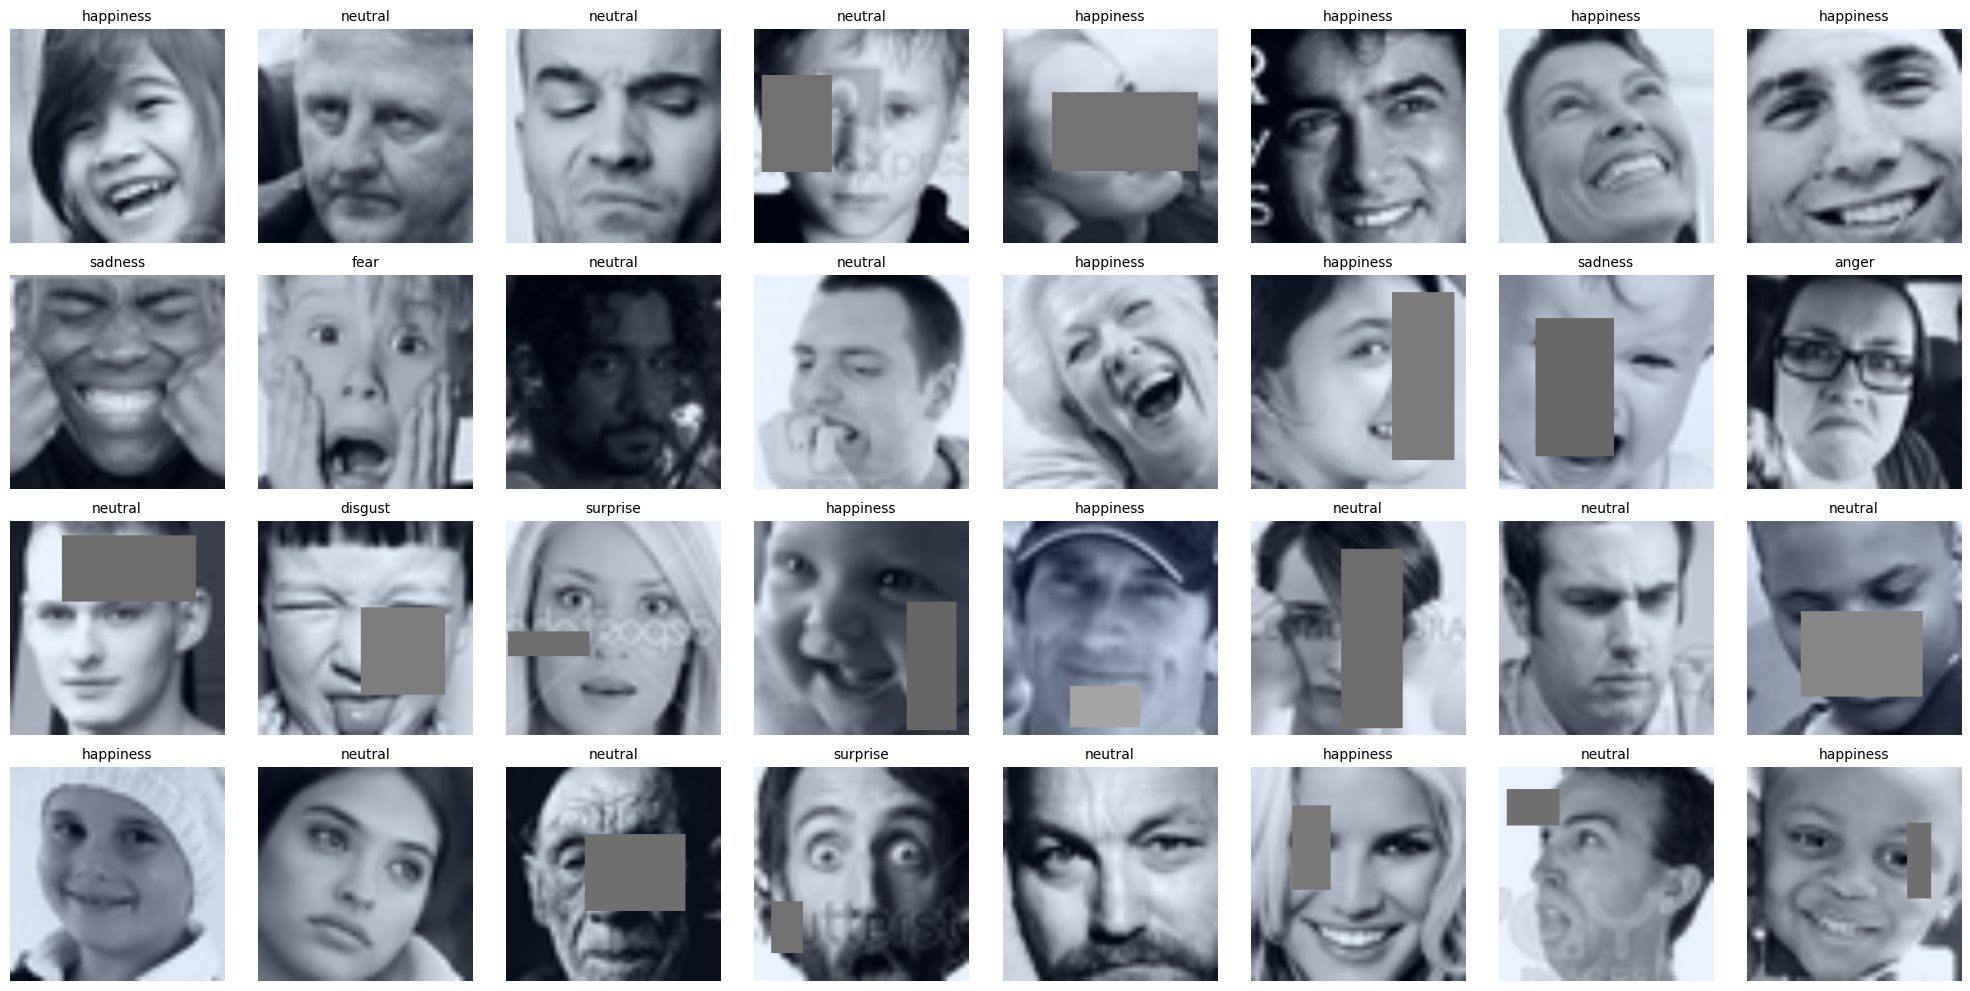

In [19]:
visualize_batch(train_loader, index_to_emotion)

In [ ]:
best_model_path = os.path.expanduser("~/FER-generalizavel/models/ours_best_FERPlus.pth")

In [ ]:
train_model(model, clip_model, train_loader, test_loader, optimizer, scheduler, device, best_model_path, epochs=args.epochs, patience = args.epochs)

In [ ]:
import os
import json

# Caminho para o seu arquivo kaggle.json
kaggle_json_path = os.path.expanduser("~/FER-generalizavel/addons/kaggle.json")

# Carrega o JSON com as credenciais
with open(kaggle_json_path) as f:
    kaggle_creds = json.load(f)

# Define as variáveis de ambiente
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

# Agora pode importar e usar a API
import kaggle

kaggle_path = os.path.expanduser("~/FER-generalizavel/data")
kaggle.api.dataset_download_files("yakhyokhuja/affectnetaligned", path=kaggle_path, unzip=True)

In [ ]:
emotion_to_index = {
            "angry": 0,
            "disgust": 1,
            "fear": 2,
            "happiness": 3,
            "sadness": 4,
            "surprise": 5,
            "neutral": 6
        }

index_to_emotion = {v: k for k, v in emotion_to_index.items()}

In [ ]:
from torch.utils.data import Dataset

class AffectNetDataset(Dataset):
    def __init__(self, root_dir, idx_aff, idx_test, split="train", transform=None):
        """
        Args:
            root_dir (str): Diretório raiz contendo as pastas train, test e valid.
            split (str): Qual partição carregar ("train", "test" ou "valid").
            transform (callable, optional): Transformações a serem aplicadas às imagens.
        """
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.idxs_test = idx_test
        self.idxs_aff = idx_aff
        
        self.class_map = {
            "angry": 0,
            "disgust": 1,
            "fear": 2,
            "happiness": 3,
            "sadness": 4,
            "surprise": 5,
            "neutral": 6
        }
        
        self.samples = []
        for class_idx in range(len(self.class_map)):  # Pastas nomeadas por índice
            class_path = os.path.join(self.root_dir, str(class_idx))
            if os.path.exists(class_path):
                for filename in os.listdir(class_path):
                    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filtra apenas imagens
                        self.samples.append((os.path.join(class_path, filename), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        label = self.idxs_test[self.idxs_aff[label]]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
root_dir = os.path.expanduser("~/FER-generalizavel/data/AffectNetCustom") 

In [ ]:
train_dataset = AffectNetDataset(root_dir=root_dir, idx_aff=index_to_emotion, idx_test=emotion_to_index, split="train", transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           #batch_size=1,
                                           shuffle=True,
                                           num_workers=args.workers,
                                           pin_memory=True)

In [ ]:
test_dataset = AffectNetDataset(root_dir=root_dir, idx_aff=index_to_emotion, idx_test=emotion_to_index, split="test", transform=eval_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [ ]:
import matplotlib.pyplot as plt

# Obtendo o batch de imagens e rótulos
for images, labels in train_loader:
    # Se você quiser mostrar apenas um batch
    break

# Definindo o layout para 4 linhas e 8 colunas
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4x8 layout
axes = axes.flatten()  # Flatten para facilitar a iteração

# Loop para exibir as imagens no grid
for i, (img, label) in enumerate(zip(images, labels)):
    if i >= len(axes):  # Se houver mais imagens do que subgráficos
        break

    # Convertendo a imagem para numpy e normalizando
    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Exibindo a imagem
    ax = axes[i]
    ax.imshow(img_np)
    ax.axis('off')  # Desativar os eixos

    # Usando o mapa de rótulos para mostrar o nome da emoção
    label_name = index_to_emotion[label.item()]
    ax.set_title(f"{label_name}", fontsize=10)  # Título com o nome do label

# Ajustar o layout para não sobrepor as imagens
plt.tight_layout()
plt.show()

In [ ]:
model_path = '/home/uc1add2a09dc85742dea98fbdba71022/FER-generalizavel/models/resnet18_msceleb.pth'
model = Model(model_path = model_path)
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
model.to(device)

In [ ]:
best_acc = 0
patience = 5  # Number of epochs to wait for improvement
no_improvement = 0

for i in range(1, args.epochs + 1):
    train_acc, train_loss = train(model, train_loader, optimizer, scheduler, device)
    test_acc, test_loss = test(model, test_loader, device)
    print('epoch: ', i, 'acc_test: ', test_acc, 'acc_train: ', train_acc)

    # Early stopping logic with patience
    if test_acc > best_acc:
        best_acc = test_acc
        no_improvement = 0  # Reset patience counter on improvement
        torch.save({'model_state_dict': model.state_dict(),},  os.path.expanduser("~/FER-generalizavel/models/ours_best_Affectnet.pth"))
    else:
        continue
        #no_improvement += 1  # Increment patience counter on no improvement

    """
    if no_improvement == patience:
        print(f"Early stopping after {i} epochs with no improvement in test accuracy")
        break  # Exit the training loop if patience is exhausted

    torch.save({'model_state_dict': model.state_dict(),}, "/kaggle/working/ours_final_AffectNet.pth")
    with open('results.txt', 'a') as f:
        f.write(str(i)+'_'+str(test_acc)+'\n')
    """

In [ ]:
import os
import json

# Caminho para o seu arquivo kaggle.json
kaggle_json_path = os.path.expanduser("~/FER-generalizavel/addons/kaggle.json")

# Carrega o JSON com as credenciais
with open(kaggle_json_path) as f:
    kaggle_creds = json.load(f)

# Define as variáveis de ambiente
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

# Agora pode importar e usar a API
import kaggle

kaggle_path = os.path.expanduser("~/FER-generalizavel/data")
kaggle.api.dataset_download_files("mahmoudima/mma-facial-expression", path=kaggle_path, unzip=True)

In [ ]:
emotion_to_index = {
            "angry": 0,
            "disgust": 1,
            "fear": 2,
            "happiness": 3,
            "sadness": 5,
            "surprise": 6,
            "neutral": 4
        }

index_to_emotion = {v: k for k, v in emotion_to_index.items()}

In [ ]:
class MMADataset(Dataset):
    def __init__(self, root_dir, idx_mma, idx_test, split="train", transform=None):
        """
        Args:
            root_dir (str): Diretório raiz contendo as pastas train, test e valid.
            split (str): Qual partição carregar ("train", "test" ou "valid").
            transform (callable, optional): Transformações a serem aplicadas às imagens.
        """
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = sorted(os.listdir(self.root_dir))  # Lista de emoções
        self.idxs_test = idx_test
        self.idxs_mma = idx_mma
        
        self.samples = []
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filtra apenas imagens
                    self.samples.append((os.path.join(class_path, filename), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        label = self.idxs_test[self.idxs_mma[label]]
        
        return image, label

In [ ]:
root_dir = os.path.expanduser("~/FER-generalizavel/data") "/kaggle/input/mma-facial-expression/MMAFEDB"

In [ ]:
train_dataset = MMADataset(root_dir=root_dir, idx_mma=index_to_emotion, idx_test=emotion_to_index, split="train", transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           #batch_size=1,
                                           shuffle=True,
                                           num_workers=args.workers,
                                           pin_memory=True)

In [ ]:
test_dataset = MMADataset(root_dir=root_dir, idx_mma=index_to_emotion, idx_test=emotion_to_index, split="test", transform=eval_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [ ]:
import matplotlib.pyplot as plt

# Obtendo o batch de imagens e rótulos
for images, labels in train_loader:
    # Se você quiser mostrar apenas um batch
    break

# Definindo o layout para 4 linhas e 8 colunas
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4x8 layout
axes = axes.flatten()  # Flatten para facilitar a iteração

# Loop para exibir as imagens no grid
for i, (img, label) in enumerate(zip(images, labels)):
    if i >= len(axes):  # Se houver mais imagens do que subgráficos
        break

    # Convertendo a imagem para numpy e normalizando
    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Exibindo a imagem
    ax = axes[i]
    ax.imshow(img_np)
    ax.axis('off')  # Desativar os eixos

    # Usando o mapa de rótulos para mostrar o nome da emoção
    label_name = index_to_emotion[label.item()]
    ax.set_title(f"{label_name}", fontsize=10)  # Título com o nome do label

# Ajustar o layout para não sobrepor as imagens
plt.tight_layout()
plt.show()

In [ ]:
model_path = '/home/uc1add2a09dc85742dea98fbdba71022/FER-generalizavel/models/resnet18_msceleb.pth'
model = Model(model_path = model_path)
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
model.to(device)

In [ ]:
best_acc = 0
patience = 5  # Number of epochs to wait for improvement
no_improvement = 0

for i in range(1, args.epochs + 1):
    train_acc, train_loss = train(model, train_loader, optimizer, scheduler, device)
    test_acc, test_loss = test(model, test_loader, device)
    print('epoch: ', i, 'acc_test: ', test_acc, 'acc_train: ', train_acc)

    # Early stopping logic with patience
    if test_acc > best_acc:
        best_acc = test_acc
        no_improvement = 0  # Reset patience counter on improvement
        torch.save({'model_state_dict': model.state_dict(),}, os.path.expanduser("~/FER-generalizavel/models/ours_best_MMA.pth"))
    else:
        no_improvement += 1  # Increment patience counter on no improvement

    """
    if no_improvement == patience:
        print(f"Early stopping after {i} epochs with no improvement in test accuracy")
        break  # Exit the training loop if patience is exhausted

    torch.save({'model_state_dict': model.state_dict(),}, "/kaggle/working/ours_final_MMA.pth")
    with open('results.txt', 'a') as f:
        f.write(str(i)+'_'+str(test_acc)+'\n')
    """

In [ ]:
import os
import json

# Caminho para o seu arquivo kaggle.json
kaggle_json_path = os.path.expanduser("~/FER-generalizavel/addons/kaggle.json")

# Carrega o JSON com as credenciais
with open(kaggle_json_path) as f:
    kaggle_creds = json.load(f)

# Define as variáveis de ambiente
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

# Agora pode importar e usar a API
import kaggle

kaggle_path = os.path.expanduser("~/FER-generalizavel/data")
kaggle.api.dataset_download_files("vlntnstarodub/datasetsfew", path=kaggle_path, unzip=True)

In [ ]:
emotion_to_index = {
            "angry": 0,
            "disgust": 1,
            "fear": 2,
            "happiness": 3,
            "sadness": 5,
            "surprise": 6,
            "neutral": 4
        }

index_to_emotion = {v: k for k, v in emotion_to_index.items()}

In [ ]:
from torch.utils.data import Dataset

class SFEWDataset(Dataset):
    def __init__(self, root_dir, idx_test, idx_sfew, split="Train", transform=None):
        """
        Args:
            root_dir (str): Diretório raiz contendo as pastas train, test e valid.
            split (str): Qual partição carregar ("train", "test" ou "valid").
            transform (callable, optional): Transformações a serem aplicadas às imagens.
        """
        self.root_dir = os.path.join(root_dir, split, "Test_Aligned_Faces") if split == "Test" else os.path.join(root_dir, split)
        print(self.root_dir)
        self.transform = transform
        self.classes = sorted(os.listdir(self.root_dir))  # Lista de emoções
        self.idxs_test = idx_test
        self.idxs_sfew = idx_sfew
        
        self.samples = []
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filtra apenas imagens
                    self.samples.append((os.path.join(class_path, filename), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        label = self.idxs_test[self.idxs_sfew[label]]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
root_dir = os.path.expanduser("~/FER-generalizavel/data") "/kaggle/input/datasetsfew"

In [ ]:
train_dataset = SFEWDataset(root_dir=root_dir, idx_test=emotion_to_index, idx_sfew=index_to_emotion, split="Train", transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           #batch_size=1,
                                           shuffle=True,
                                           num_workers=args.workers,
                                           pin_memory=True)

In [ ]:
test_dataset = SFEWDataset(root_dir=root_dir, idx_test=emotion_to_index, idx_sfew=index_to_emotion, split="Val", transform=train_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [ ]:
import matplotlib.pyplot as plt

# Obtendo o batch de imagens e rótulos
for images, labels in train_loader:
    # Se você quiser mostrar apenas um batch
    break

# Definindo o layout para 4 linhas e 8 colunas
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4x8 layout
axes = axes.flatten()  # Flatten para facilitar a iteração

# Loop para exibir as imagens no grid
for i, (img, label) in enumerate(zip(images, labels)):
    if i >= len(axes):  # Se houver mais imagens do que subgráficos
        break

    # Convertendo a imagem para numpy e normalizando
    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Exibindo a imagem
    ax = axes[i]
    ax.imshow(img_np)
    ax.axis('off')  # Desativar os eixos

    # Usando o mapa de rótulos para mostrar o nome da emoção
    label_name = index_to_emotion[label.item()]
    ax.set_title(f"{label_name}", fontsize=10)  # Título com o nome do label

# Ajustar o layout para não sobrepor as imagens
plt.tight_layout()
plt.show()

In [ ]:
model_path = '/home/uc1add2a09dc85742dea98fbdba71022/FER-generalizavel/models/resnet18_msceleb.pth'
model = Model(model_path = model_path)
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
model.to(device)

In [ ]:
best_acc = 0
patience = 100  # Number of epochs to wait for improvement
no_improvement = 0

for i in range(1, args.epochs + 1):
    train_acc, train_loss = train(model, train_loader, optimizer, scheduler, device)
    test_acc, test_loss = test(model, test_loader, device)
    print('epoch: ', i, 'acc_test: ', test_acc, 'acc_train: ', train_acc)

    # Early stopping logic with patience
    if test_acc > best_acc:
        best_acc = test_acc
        no_improvement = 0  # Reset patience counter on improvement
        torch.save({'model_state_dict': model.state_dict(),}, os.path.expanduser("~/FER-generalizavel/models/ours_best_sfew.pth"))
    else:
        no_improvement += 1  # Increment patience counter on no improvement

    """
    if no_improvement == patience:
        print(f"Early stopping after {i} epochs with no improvement in test accuracy")
        break  # Exit the training loop if patience is exhausted

    torch.save({'model_state_dict': model.state_dict(),}, "/kaggle/working/ours_final_SFEW.pth")
    with open('results.txt', 'a') as f:
        f.write(str(i)+'_'+str(test_acc)+'\n')
    """

### Teste entre dominios

In [20]:
import emotion_datasets
from emotion_datasets import SFEWDataset, MMADataset, AffectNetDataset, RafDataSet, FERPlusDataset

In [21]:
from aux.emotion_idx import *

In [22]:
from aux.load_weights import *

In [23]:
from aux.test import *

In [24]:
root_dir = os.path.expanduser("~/FER-generalizavel/data/datasetsfew")
dataset_sfew = SFEWDataset(root_dir=root_dir, idx_test=emotion_to_index_sfew, idx_sfew=index_to_emotion_sfew, split="Val", transform=train_transforms)
loader_sfew = torch.utils.data.DataLoader(dataset_sfew, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

/home/uc1add2a09dc85742dea98fbdba71022/FER-generalizavel/data/datasetsfew/Val


In [25]:
root_dir = os.path.expanduser("~/FER-generalizavel/data/MMAFEDB")
dataset_mma = MMADataset(root_dir=root_dir, idx_test=emotion_to_index_sfew, idx_mma=index_to_emotion_mma, split="test", transform=eval_transforms)
loader_mma = torch.utils.data.DataLoader(dataset_mma, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [26]:
root_dir = os.path.expanduser("~/FER-generalizavel/data/AffectNetCustom")
dataset_affect = AffectNetDataset(root_dir=root_dir, idx_test=emotion_to_index_sfew, idx_aff=index_to_emotion_aff, split="test", transform=eval_transforms)
loader_affect = torch.utils.data.DataLoader(dataset_affect, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [27]:
root_dir = os.path.expanduser("~/FER-generalizavel/data/raf-basic")
dataset_raf = RafDataSet(root_dir, idxs_test=emotion_to_index_sfew, idxs_raf=index_to_emotion_raf, train=False, transform=train_transforms)
loader_raf = torch.utils.data.DataLoader(dataset_raf,
                                           batch_size=args.batch_size,
                                           #batch_size=1,
                                           shuffle=False,
                                           num_workers=args.workers,
                                           pin_memory=True)

In [28]:
root_dir = os.path.expanduser("~/FER-generalizavel/data/FER2013Plus")
dataset_fer = FERPlusDataset(root_dir=root_dir, idxs_test=emotion_to_index_sfew, idxs_fer=index_to_emotion_fer, subset="FER2013Test", transform=eval_transforms)
loader_fer = torch.utils.data.DataLoader(dataset_fer, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [29]:
best_model_path = os.path.expanduser("~/FER-generalizavel/models/ours_best_FERPlus.pth")

In [30]:
checkpoint = torch.load(best_model_path)
checkpoint = checkpoint["model_state_dict"]
model = load_pretrained_weights(model, checkpoint)
model.to(device)

load_weight 122


Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [31]:
###### SFEW
acc_sfew, test_loss = test(model, clip_model, loader_sfew, device)
print('test acc dbtrain-fer dbtest-sfew: ', acc_sfew)

###### FER
acc_fer, test_loss = test(model, clip_model, loader_fer, device)
print('test acc dbtrain-fer dbtest-fer: ', acc_fer)

###### AFFECT
acc_affect, test_loss = test(model, clip_model, loader_affect, device)
print('test acc dbtrain-fer dbtest-affect: ', acc_affect)

###### MMA
acc_mma, test_loss = test(model, clip_model, loader_mma, device)
print('test acc dbtrain-fer dbtest-mma: ', acc_mma)

### RAFDB
acc_raf, test_loss = test(model, clip_model, loader_raf, device)
print('test acc dbtrain-fer dbtest-raf: ', acc_raf)

test acc dbtrain-fer dbtest-sfew:  tensor(0.1299, device='xpu:0')
test acc dbtrain-fer dbtest-fer:  tensor(0.0308, device='xpu:0')
test acc dbtrain-fer dbtest-affect:  tensor(0.1697, device='xpu:0')
test acc dbtrain-fer dbtest-mma:  tensor(0.0436, device='xpu:0')
test acc dbtrain-fer dbtest-raf:  tensor(0.0228, device='xpu:0')


In [ ]:
root_dir = "/kaggle/input/datasetsfew"
dataset_sfew = SFEWDataset(root_dir=root_dir, idx_test=emotion_to_index_mma, idx_sfew=index_to_emotion_sfew, split="Val", transform=train_transforms)
loader_sfew = torch.utils.data.DataLoader(dataset_sfew, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

root_dir = "/kaggle/input/mma-facial-expression/MMAFEDB"
dataset_mma = MMADataset(root_dir=root_dir, idx_test=emotion_to_index_mma, idx_mma=index_to_emotion_mma, split="test", transform=eval_transforms)
loader_mma = torch.utils.data.DataLoader(dataset_mma, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

root_dir = "/kaggle/input/affectnetaligned/AffectNetCustom"
dataset_affect = AffectNetDataset(root_dir=root_dir, idx_test=emotion_to_index_mma, idx_aff=index_to_emotion_aff, split="test", transform=eval_transforms)
loader_affect = torch.utils.data.DataLoader(dataset_affect, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

dataset_raf = RafDataSet('/kaggle/input/eacdata/raf-basic', idxs_test=emotion_to_index_mma, idxs_raf=index_to_emotion_raf, train=False, transform=train_transforms)
loader_raf = torch.utils.data.DataLoader(dataset_raf,
                                           batch_size=args.batch_size,
                                           #batch_size=1,
                                           shuffle=False,
                                           num_workers=args.workers,
                                           pin_memory=True)

root_dir = "/kaggle/input/ferplus/FER2013Plus"
dataset_fer = FERPlusDataset(root_dir=root_dir, idxs_test=emotion_to_index_mma, idxs_fer=index_to_emotion_fer, subset="FER2013Test", transform=eval_transforms)
loader_fer = torch.utils.data.DataLoader(dataset_fer, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [ ]:
checkpoint = torch.load('/kaggle/working/ours_best_MMA.pth')
checkpoint = checkpoint["model_state_dict"]
model = load_pretrained_weights(model, checkpoint)
model.to(device)

In [ ]:
###### SFEW
acc_mma_sfew, test_loss = test(model, loader_sfew, device)
print('test acc dbtrain-mma dbtest-sfew: ', acc_mma_sfew)

###### FER
acc_mma_fer, test_loss = test(model, loader_fer, device)
print('test acc dbtrain-mma dbtest-fer: ', acc_mma_fer)

###### AFFECT
acc_mma_affect, test_loss = test(model, loader_affect, device)
print('test acc dbtrain-mma dbtest-affect: ', acc_mma_affect)

###### MMA
acc_mma_mma, test_loss = test(model, loader_mma, device)
print('test acc dbtrain-mma dbtest-mma: ', acc_mma_mma)

### RAFDB
acc_mma_raf, test_loss = test(model, loader_raf, device)
print('test acc dbtrain-mma dbtest-raf: ', acc_mma_raf)

In [ ]:
root_dir = "../data/datasetsfew"
dataset_sfew = SFEWDataset(root_dir=root_dir, idx_test=emotion_to_index_raf, idx_sfew=index_to_emotion_sfew, split="Val", transform=eval_transforms)
loader_sfew = torch.utils.data.DataLoader(dataset_sfew, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

root_dir = "../data/MMAFEDB"
dataset_mma = MMADataset(root_dir=root_dir, idx_test=emotion_to_index_raf, idx_mma=index_to_emotion_mma, split="test", transform=eval_transforms)
loader_mma = torch.utils.data.DataLoader(dataset_mma, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

root_dir = "../data/AffectNetCustom"
dataset_affect = AffectNetDataset(root_dir=root_dir, idx_test=emotion_to_index_raf, idx_aff=index_to_emotion_aff, split="test", transform=eval_transforms)
loader_affect = torch.utils.data.DataLoader(dataset_affect, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

dataset_raf = RafDataSet('../data/raf-basic', idxs_test=emotion_to_index_raf, idxs_raf=index_to_emotion_raf, train=False, transform=eval_transforms)
loader_raf = torch.utils.data.DataLoader(dataset_raf,
                                           batch_size=args.batch_size,
                                           #batch_size=1,
                                           shuffle=False,
                                           num_workers=args.workers,
                                           pin_memory=True)

root_dir = "../data/FER2013Plus"
dataset_fer = FERPlusDataset(root_dir=root_dir, idxs_test=emotion_to_index_raf, idxs_fer=index_to_emotion_fer, subset="FER2013Test", transform=eval_transforms)
loader_fer = torch.utils.data.DataLoader(dataset_fer, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [ ]:
checkpoint = torch.load('../models/ours_best_RAFDB.pth')
checkpoint = checkpoint["model_state_dict"]
model = load_pretrained_weights(model, checkpoint)
model.to(device)

In [ ]:
### RAFDB
acc_raf_raf, test_loss = test(model, loader_raf, device)
print('test acc dbtrain-raf dbtest-raf: ', acc_raf_raf)

###### FER
acc_raf_fer, test_loss = test(model, loader_fer, device)
print('test acc dbtrain-raf dbtest-fer: ', acc_raf_fer)

###### AFFECT
acc_raf_affect, test_loss = test(model, loader_affect, device)
print('test acc dbtrain-raf dbtest-affect: ', acc_raf_affect)

###### SFEW
acc_raf_sfew, test_loss = test(model, loader_sfew, device)
print('test acc dbtrain-raf dbtest-sfew: ', acc_raf_sfew)

###### MMA
acc_raf_mma, test_loss = test(model, loader_mma, device)
print('test acc dbtrain-raf dbtest-mma: ', acc_raf_mma)